In [1]:
from multiprocessing import Pool, cpu_count

import IPython.display as ipd
import librosa
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow.keras as keras
import tensorflow.keras.backend as K
import tensorflow_addons as tfa
from sklearn.metrics import f1_score
from tensorflow import keras
from tqdm import tqdm

from lib.float2d_to_rgb_layer import Float2DToRGB
from lib.power_to_db_layer import PowerToDb
from lib.utils import fix_random_seed, float2d_to_rgb, read_json
from src.config import c
from src.data_utils import (
    boost_multiple_occurences,
    geofilter_predictions,
    normalize_soundscapes_df,
    predictions_to_text_labels,
    read_soundscapes_info,
)
from src.generator import Generator
from src.geo_filter import filters as geo_filters
from src.models import Div, SinCos, YMToDate
from src.services import get_msg_provider, get_wave_provider

In [2]:
wave_p = get_wave_provider(c)
c["MSG_POWER_TO_DB"] = False
msg_p = get_msg_provider(c)


generator = Generator(
    df=pd.read_pickle("/app/_work/dataset-C.pickle"),
    shuffle=False,
    augmentation=None,
    rating_as_sw=False,
    rareness_as_sw=False,
    msg_provider=msg_p,
    wave_provider=wave_p,
    msg_output_size=(256, 256),
    msg_power=3,
    batch_size=25,
)

In [3]:
generator._shuffle_samples()
x, _, _ = generator.__getitem__(0)
msgs = x["i_msg"]
msgs.shape

(25, 256, 256)

In [4]:
i = keras.layers.Input(shape=msgs.shape[1:], dtype="float32")
x = PowerToDb(top_db=80)(i)
x = Float2DToRGB()(x)
m = keras.models.Model(inputs=[i], outputs=[x])

In [5]:
r = m.predict(msgs)
r.shape, r.dtype

((25, 256, 256, 3), dtype('uint8'))

<ipython-input-6-3d5b6bb9952e>:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7, 3.5))


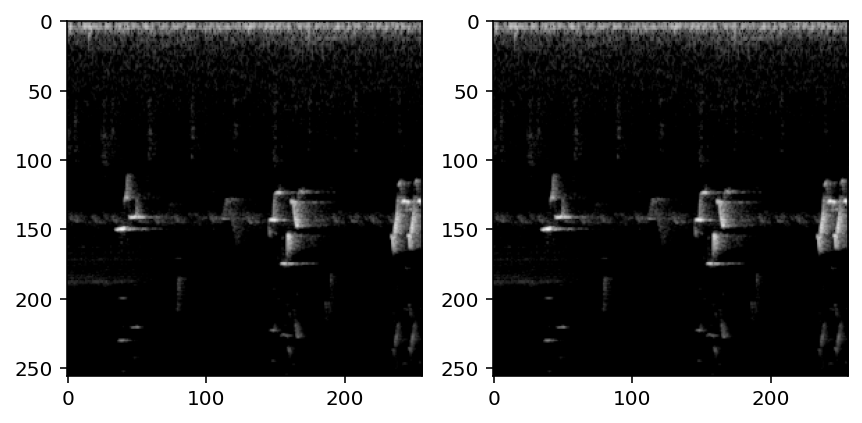

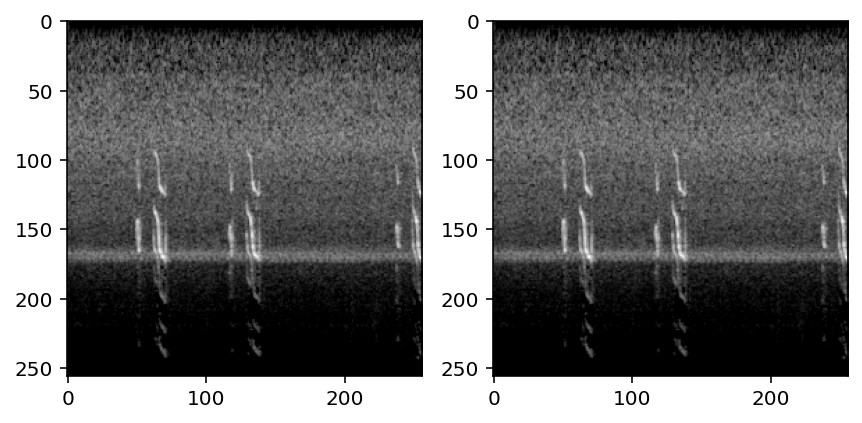

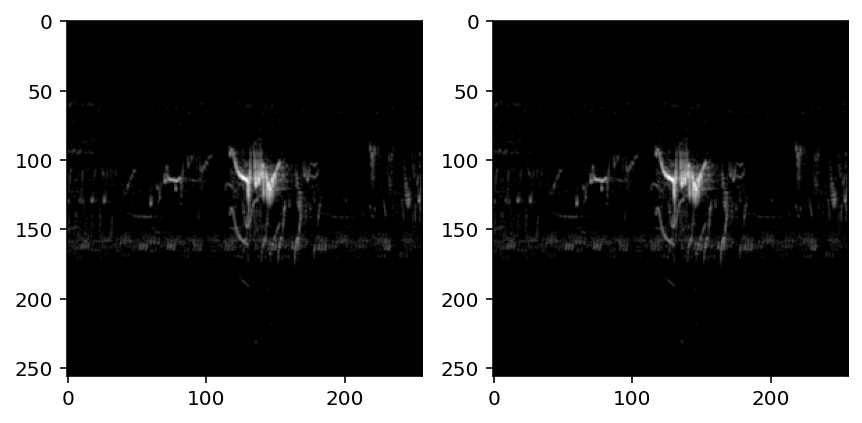

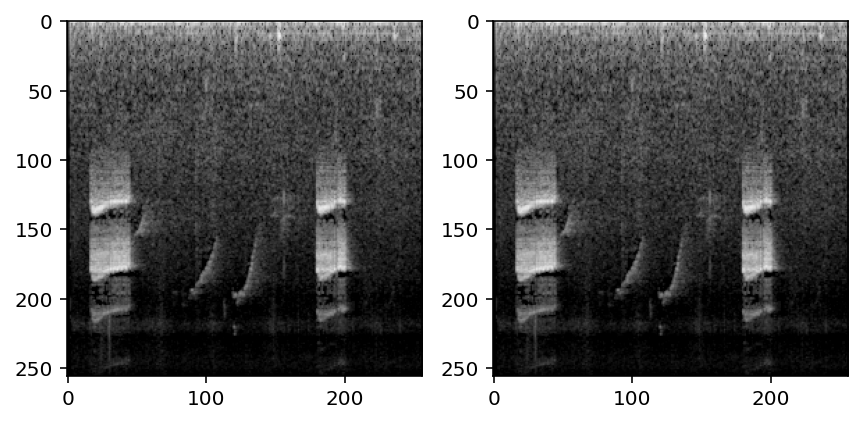

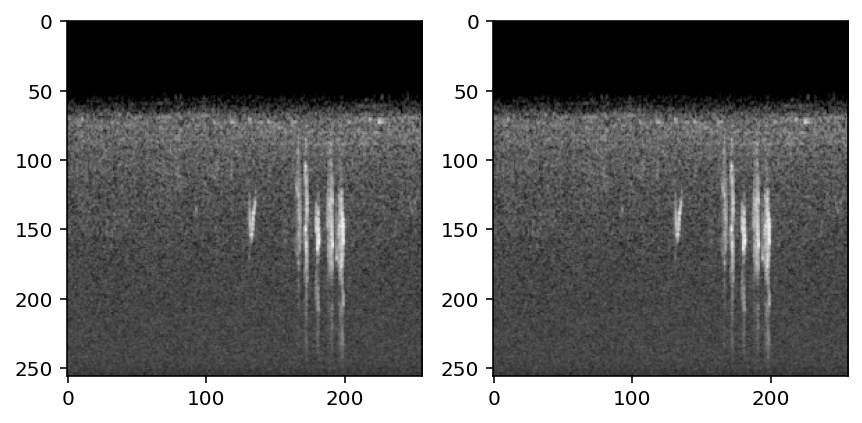

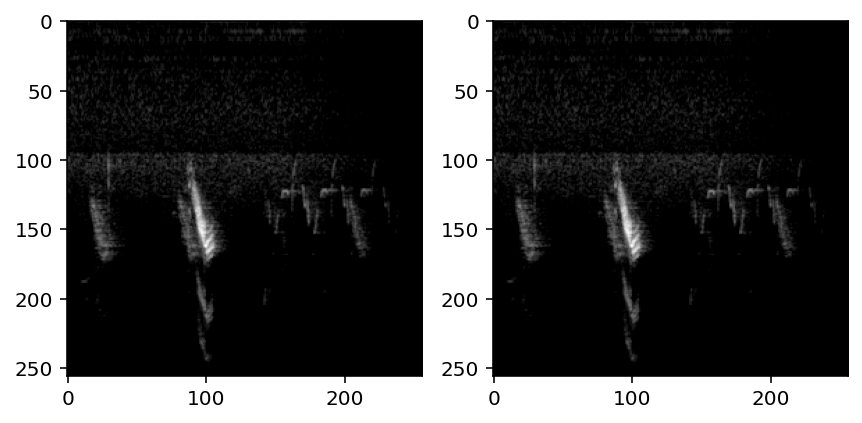

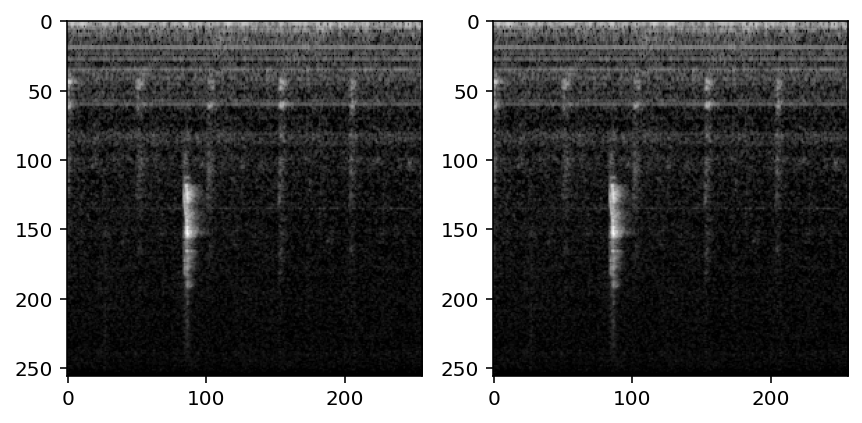

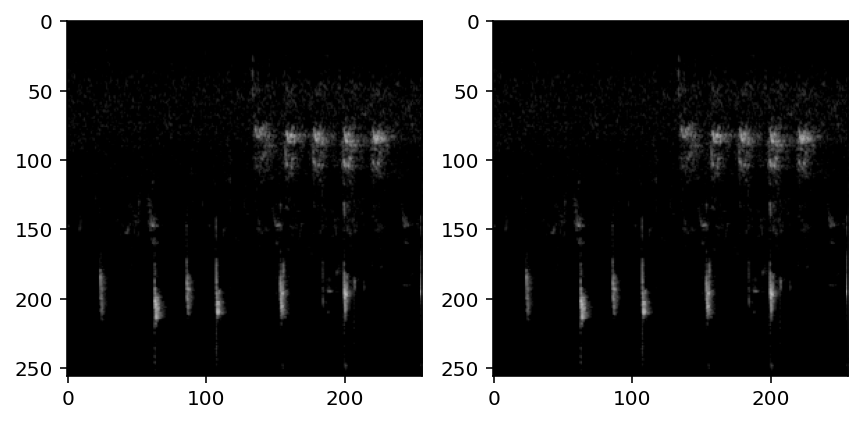

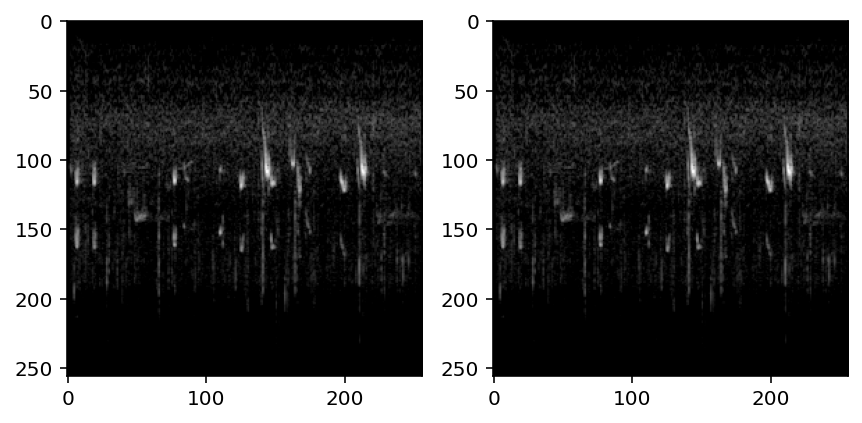

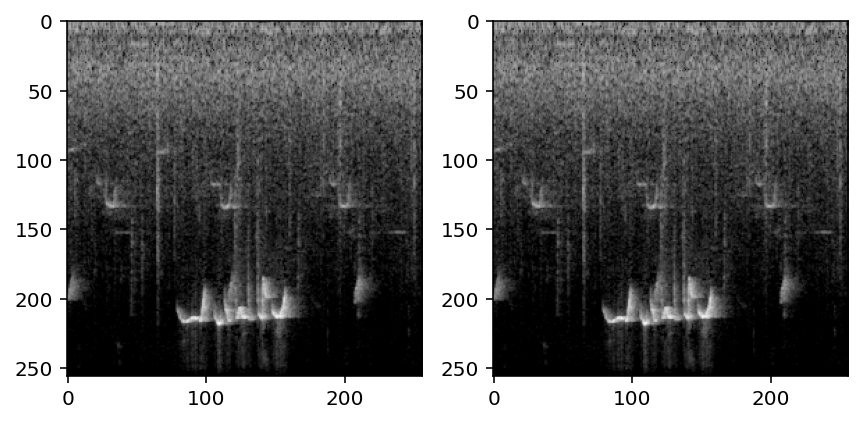

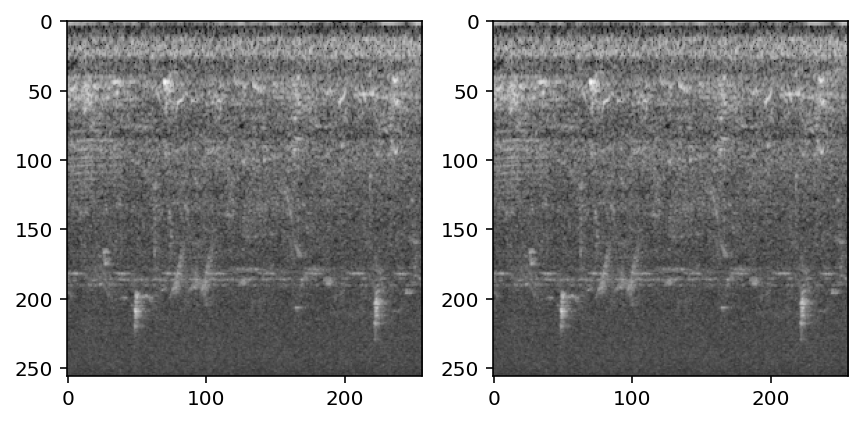

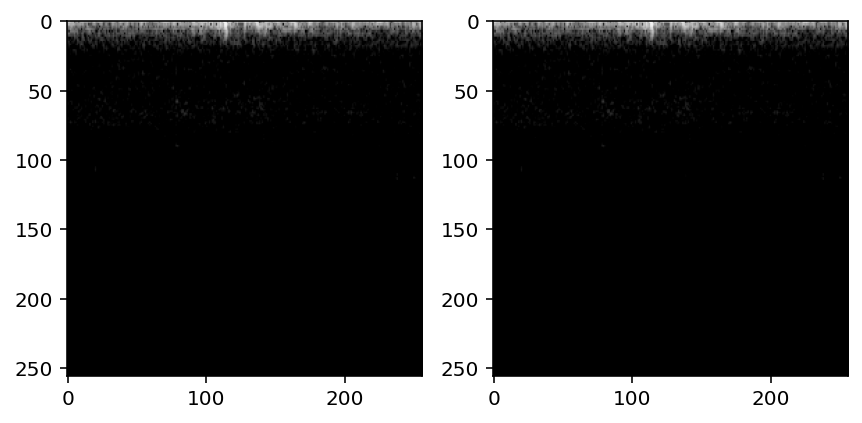

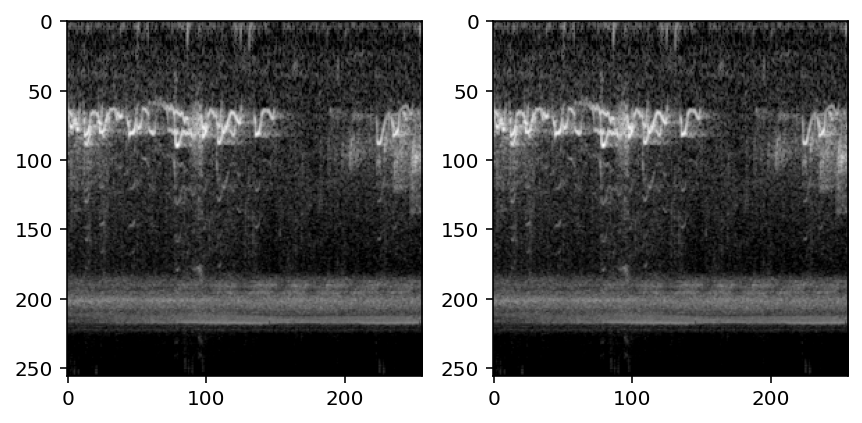

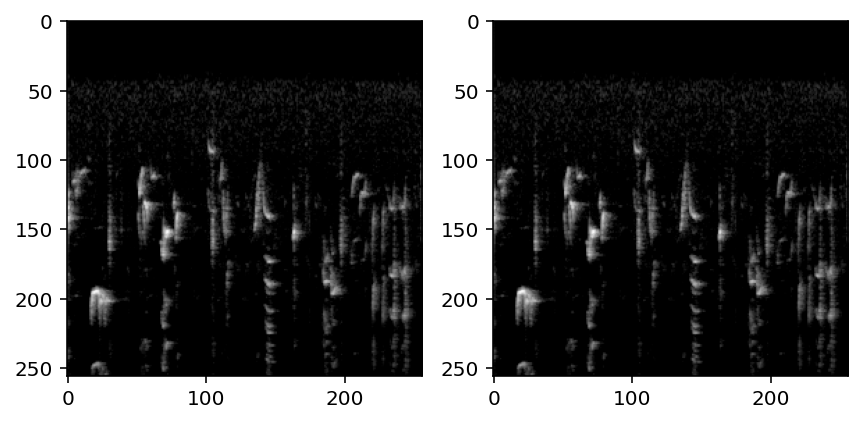

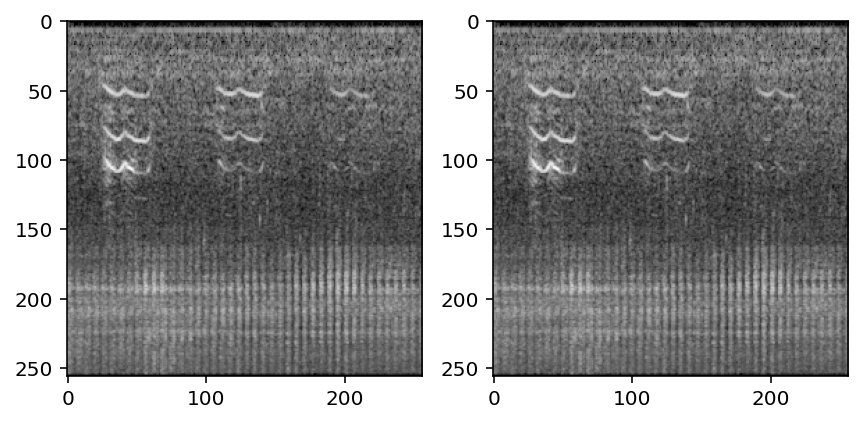

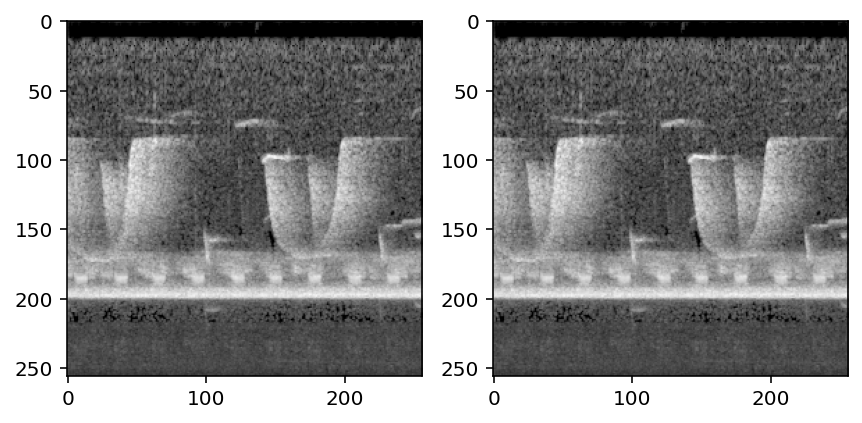

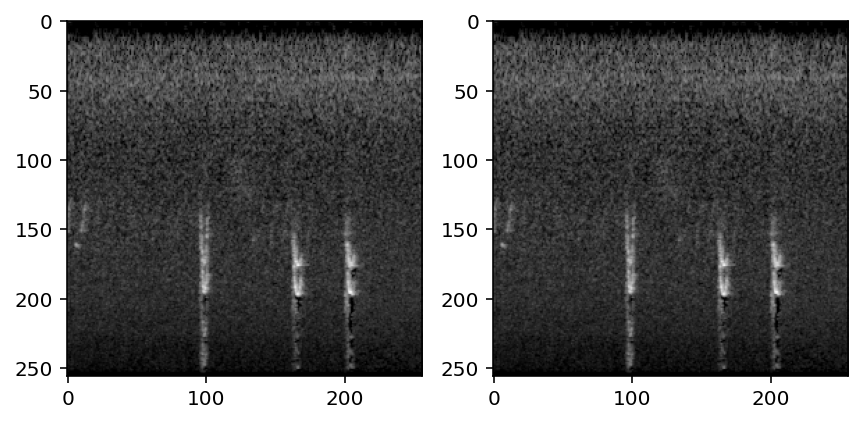

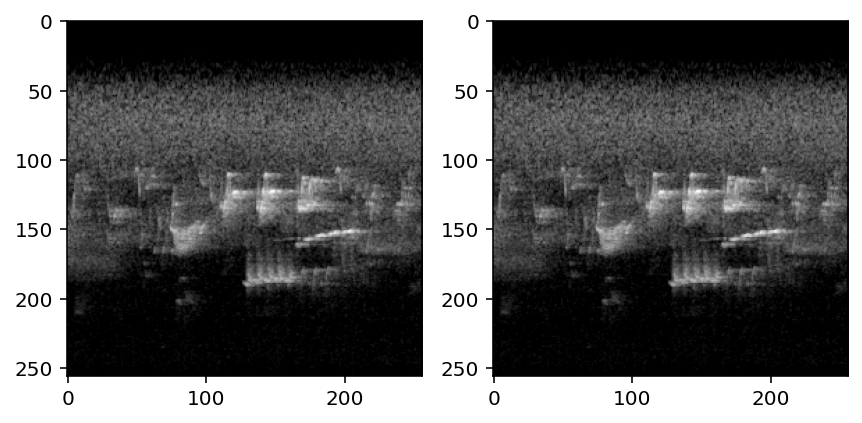

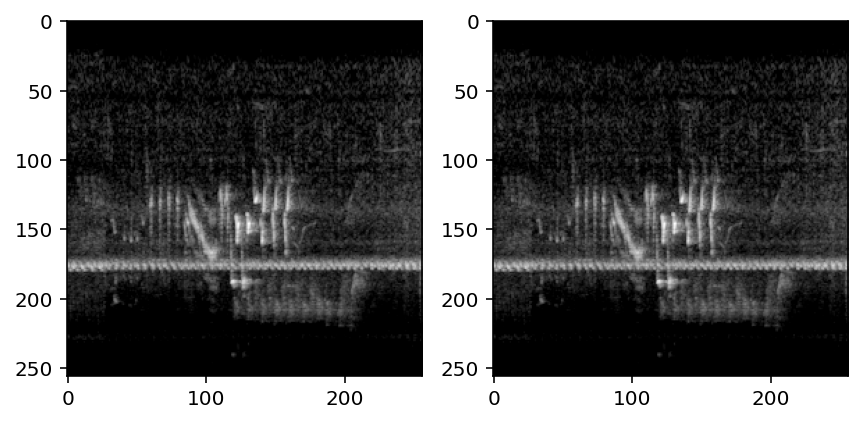

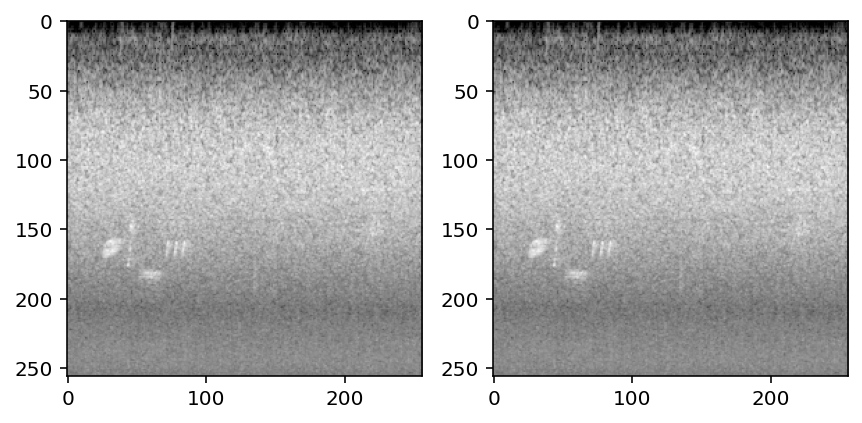

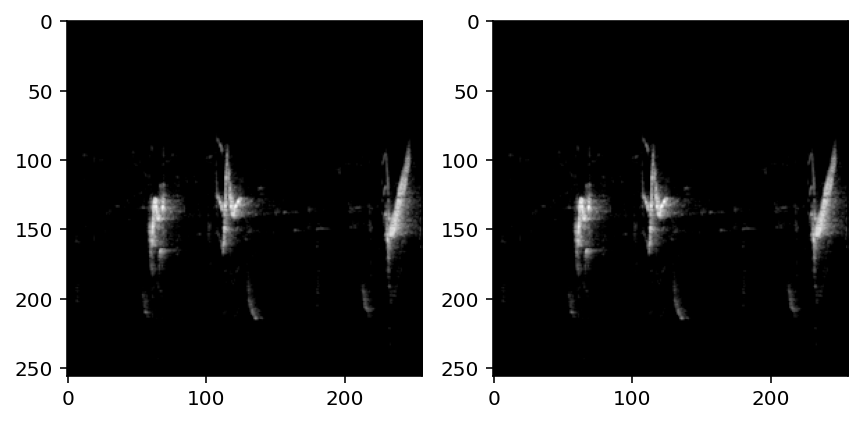

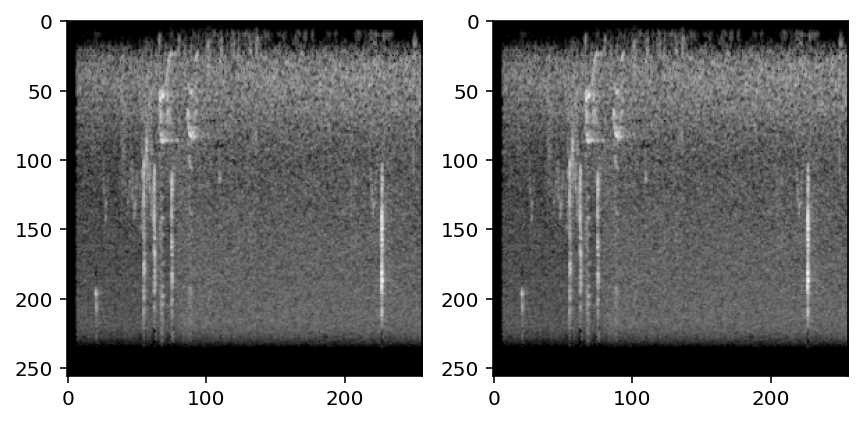

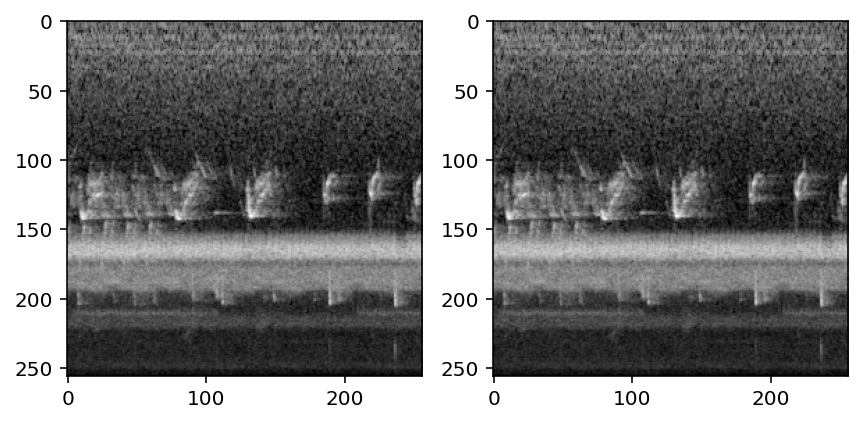

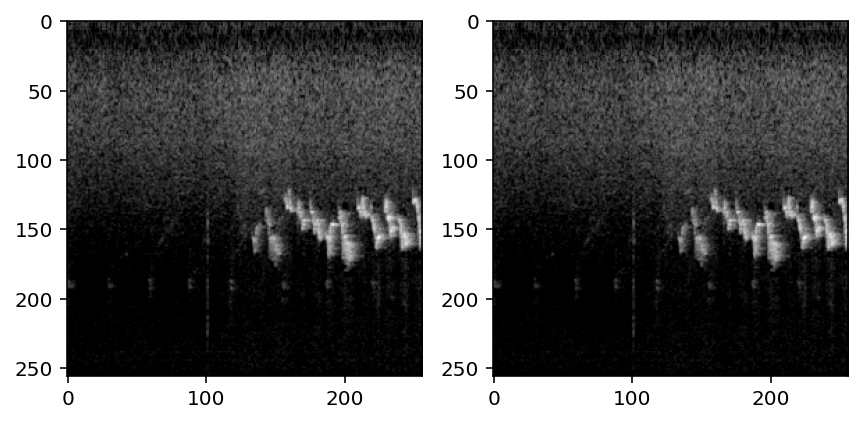

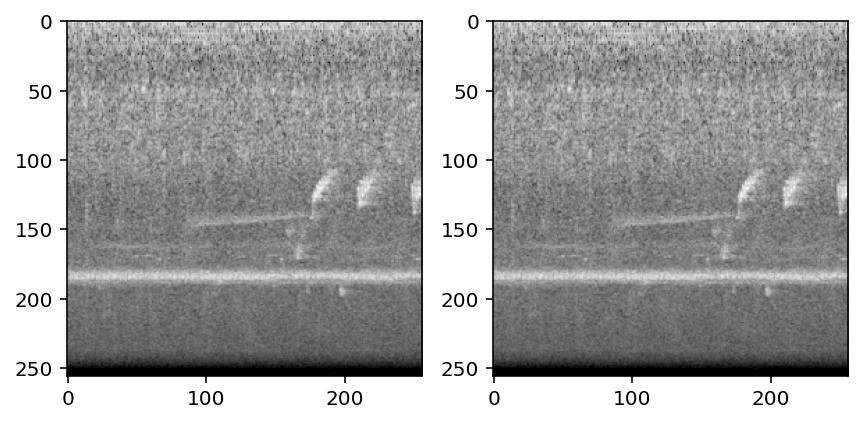

In [6]:
for i in range(len(msgs)):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7, 3.5))
    a = r[i]
    b = float2d_to_rgb(librosa.power_to_db(msgs[i]))
    ax1.imshow(a)
    ax2.imshow(b)
    assert  abs(a.std() - b.std()) < 1e-4
    fig.show()